In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import seaborn as sns

In [2]:
import re


def load_data_from_folders(path_to_dir: pathlib.Path) -> pd.DataFrame:
    records = []
    for exp_path in path_to_dir.iterdir():
        exp_name = exp_path.name
        if not exp_path.is_dir():
            continue
        for model_path in exp_path.iterdir():
            if model_path.is_dir():
                model_name = model_path.name
                for dset_folder in model_path.iterdir():
                    if dset_folder.is_dir():
                        dataset_name = dset_folder.name
                        for exp_folder in dset_folder.iterdir():
                            if exp_folder.is_dir():
                                match = re.match(r"(.+?)_neg(\d+)_seed(\d+)", exp_folder.name)
                                if match:
                                    prompt_name, neg_value, seed_value = match.groups()
                                    avg_file = exp_folder / 'averages.json'
                                    if avg_file.exists():
                                        with open(avg_file, 'r') as f:
                                            avg_data = json.load(f)
                                            records.append({**avg_data, **{'experiment': exp_name, 'model': model_name, 'dataset': dataset_name, 'prompt': prompt_name, 'negatives': int(neg_value), 'seed': int(seed_value)}})
    return pd.DataFrame(records)

In [3]:
path_to_dir = pathlib.Path("~/research/remote_data/experiments/assign-agent/").expanduser()
# paths = [path_to_dir/"DeepSeek-R1-Distill-Llama-70B", path_to_dir/"Llama-3.3-70B-Instruct"]
df = load_data_from_folders(path_to_dir)
# df = df[df["prompt"].isin(["icdcm1_reas", "icdcm1_struct", "icdcm2_reas", "icdcm2_struct", "icdcm4_reas", "icdcm4_struct"])]
df.head(10)

,f1_micro,f1_macro,micro_recall,micro_precision,accuracy,prediction-bias-ratio,experiment,model,dataset,prompt,negatives,seed
0,0.779102,0.552145,0.772727,0.785582,0.406475,0.983636,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v4,3,1
1,0.402999,0.173305,0.399091,0.406984,0.136691,0.980606,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v1,5,1
2,0.878279,0.707806,0.872424,0.884214,0.534173,0.986667,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v4,1,1
3,0.719215,0.482414,0.710606,0.728035,0.336331,0.976061,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v4,5,1
4,0.652986,0.403248,0.646061,0.660062,0.253597,0.978788,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v1,1,1
5,0.995892,0.991248,0.991818,1.000000,0.955036,0.991818,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v3,0,1
6,0.467013,0.224692,0.463333,0.470751,0.160072,0.984242,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v1,3,1
7,0.995892,0.991248,0.991818,1.000000,0.955036,0.991818,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v4,0,1
8,0.719215,0.482414,0.710606,0.728035,0.336331,0.976061,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v3,5,1
9,0.878279,0.707806,0.872424,0.884214,0.534173,0.986667,mock-negatives-single,DeepSeek-R1-Distill-Llama-70B,mdace-icd10cm,per_code_v3,1,1


In [25]:
df["prompt"].unique()

array(['per_code_v4', 'per_code_v1', 'per_code_v3', 'per_code_v2',
       'structured_v4', 'reasoning_v2', 'structured_v1', 'reasoning_v3',
       'structured_v3', 'structured_v2', 'reasoning_v4', 'reasoning_v1'],
      dtype=object)

In [4]:
df["model"] = df["prompt"].apply(lambda x: "Split context" if "per_code" in x else "One context")
df["prompt_type"] = df["prompt"].apply(lambda x: "Structured" if "structured" in x else "Reasoning")
df['prompt'] = df['prompt'].map(
    {'reasoning_v1': "codes", 
     'per_code_v1': "codes",
     'structured_v1': "codes",
     'reasoning_v2': "codes+descriptions", 
     'per_code_v2': "codes+descriptions",
     'structured_v2': "codes+descriptions",
     'reasoning_v3': "codes+descriptions+notes", 
     'per_code_v3': "codes+descriptions+notes",
     'structured_v3': "codes+descriptions+notes",})
# filter out NaN values
df = df.dropna(subset=['prompt'])
df.head(10)

,f1_micro,f1_macro,micro_recall,micro_precision,accuracy,prediction-bias-ratio,experiment,model,dataset,prompt,negatives,seed,prompt_type
1,0.402999,0.173305,0.399091,0.406984,0.136691,0.980606,mock-negatives-single,Split context,mdace-icd10cm,codes,5,1,Reasoning
4,0.652986,0.403248,0.646061,0.660062,0.253597,0.978788,mock-negatives-single,Split context,mdace-icd10cm,codes,1,1,Reasoning
5,0.995892,0.991248,0.991818,1.000000,0.955036,0.991818,mock-negatives-single,Split context,mdace-icd10cm,codes+descriptions+notes,0,1,Reasoning
6,0.467013,0.224692,0.463333,0.470751,0.160072,0.984242,mock-negatives-single,Split context,mdace-icd10cm,codes,3,1,Reasoning
8,0.719215,0.482414,0.710606,0.728035,0.336331,0.976061,mock-negatives-single,Split context,mdace-icd10cm,codes+descriptions+notes,5,1,Reasoning
9,0.878279,0.707806,0.872424,0.884214,0.534173,0.986667,mock-negatives-single,Split context,mdace-icd10cm,codes+descriptions+notes,1,1,Reasoning
10,0.997570,0.996212,0.995152,1.000000,0.973022,0.995152,mock-negatives-single,Split context,mdace-icd10cm,codes,0,1,Reasoning
11,0.779102,0.552145,0.772727,0.785582,0.406475,0.983636,mock-negatives-single,Split context,mdace-icd10cm,codes+descriptions+notes,3,1,Reasoning
12,0.996808,0.991042,0.993636,1.000000,0.964029,0.993636,mock-negatives-single,Split context,mdace-icd10cm,codes+descriptions,0,1,Reasoning
13,0.870096,0.688021,0.863636,0.876653,0.535971,0.985152,mock-negatives-single,Split context,mdace-icd10cm,codes+descriptions,1,1,Reasoning


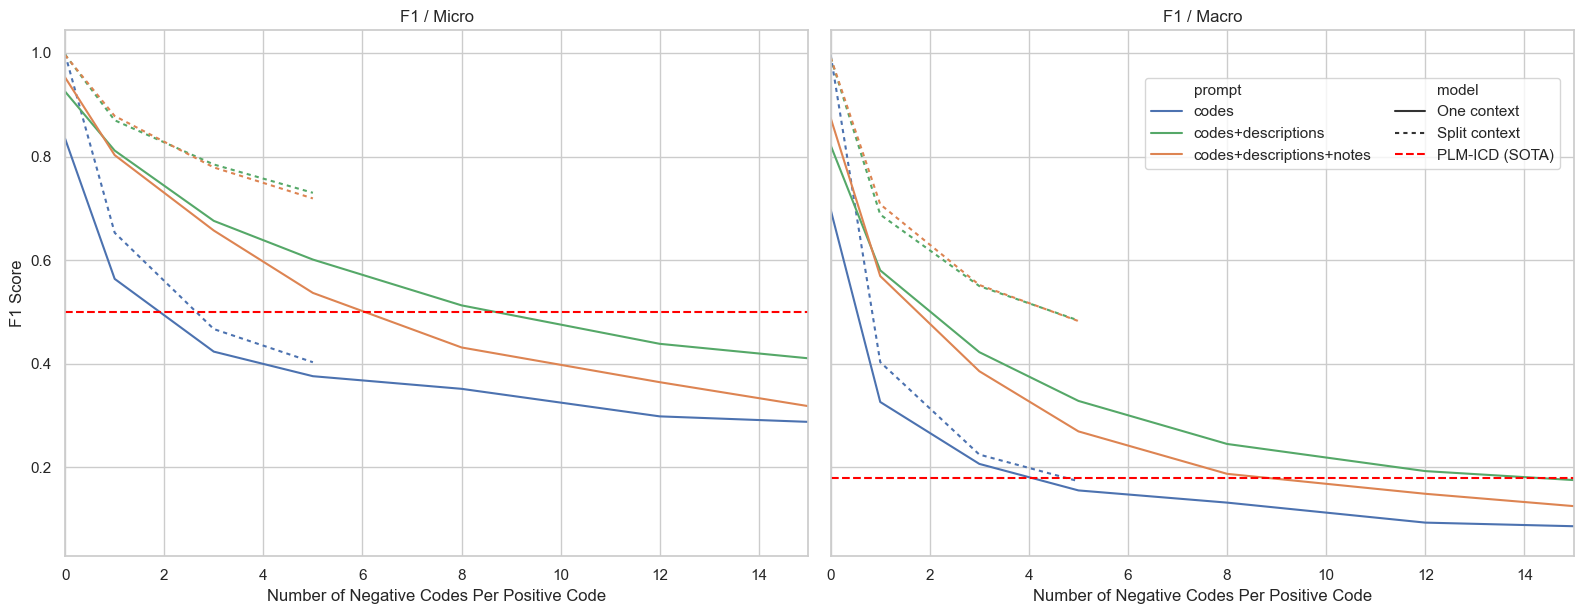

In [146]:
# Recreate the plot with the legend placed in the top right corner
# Set up the plot style
plot_df = df[df["prompt_type"] == "Reasoning"]
sns.set_theme(style="whitegrid")

# Define color palette by unique prompts
unique_prompts = df["prompt"].unique()
prompt_order = ["codes", "codes+descriptions", "codes+descriptions+notes"]
palette = dict(zip(unique_prompts, sns.color_palette(n_colors=len(unique_prompts))))
baselines = [("PLM-ICD (SOTA)", 0.50), ("PLM-ICD (SOTA)", 0.18)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for f1_micro
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    style="model",
    style_order=["One context", "Split context"],
    dashes={"One context": "", "Split context": (2, 2)},
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("F1 / Micro")
axes[0].set_ylabel("F1 Score")
axes[0].set_xlabel("Number of Negative Codes Per Positive Code")
axes[0].set_xlim([0, 15])
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")

# Plot for f1_macro
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_macro",
    hue="prompt",
    hue_order=prompt_order,
    style="model",
    style_order=["One context", "Split context"],
    dashes={"One context": "", "Split context": (2, 2)},
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("F1 / Macro")
axes[1].set_ylabel("Metric: f1_macro")
axes[1].set_xlabel("Number of Negative Codes Per Positive Code")
axes[1].set_xlim([0, 15])
axes[1].axhline(y=0.18, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")

# Place legend in the top right corner
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title=None,
    loc='upper right',
    bbox_to_anchor=(0.985, 0.92),
    ncol=2,
    columnspacing=1.5
)

# Remove individual legends from subplots
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 1.05])
plt.show()

/var/folders/wq/887fx0qd7rj2gpt8w2x8cskh0000gp/T/ipykernel_3013/4126788433.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["model"] = plot_df["model"].replace(model_renaming)


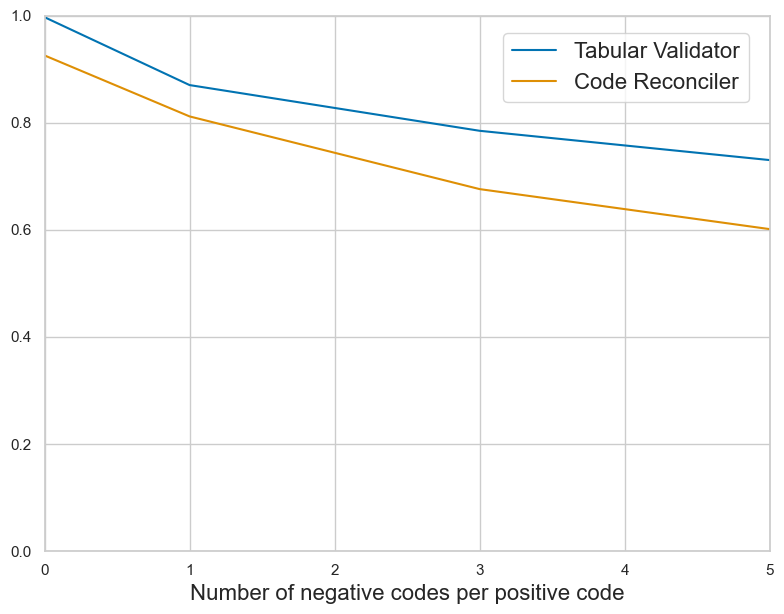

In [14]:
# Recreate the plot with the legend placed in the top right corner
# Set up the plot style
plot_df = df[(df["prompt_type"] == "Reasoning") & (df["prompt"] == "codes+descriptions")]
sns.set_theme(style="whitegrid")

# Rename model labels
model_renaming = {
    "One context": "Code Reconciler",
    "Split context": "Tabular Validator"
}
plot_df["model"] = plot_df["model"].replace(model_renaming)

# Define color palette by unique prompts
# unique_prompts = df["prompt"].unique()
# prompt_order = ["codes", "codes+descriptions", "codes+descriptions+notes"]
# palette = dict(zip(unique_prompts, sns.color_palette(n_colors=len(unique_prompts))))

fig, ax = plt.subplots(figsize=(8, 6))

# Plot for f1_micro
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="model",
    palette="colorblind",
    ax=ax
)
# ax.set_title("F1 / Micro")
ax.set_ylabel(None)
ax.set_xlabel("Number of negative codes per positive code", fontsize=16)
ax.set_xlim([0, 5])
ax.set_ylim([0.0, 1.0])

# Remove the automatic legend
ax.legend_.remove()

# Custom legend in the top right
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title=None,
    loc='upper right',
    bbox_to_anchor=(0.96, 1.0),
    ncol=1,
    columnspacing=1.5,
    prop={'size': 16},
)

plt.tight_layout(rect=[0, 0, 1, 1.05])
plt.show()


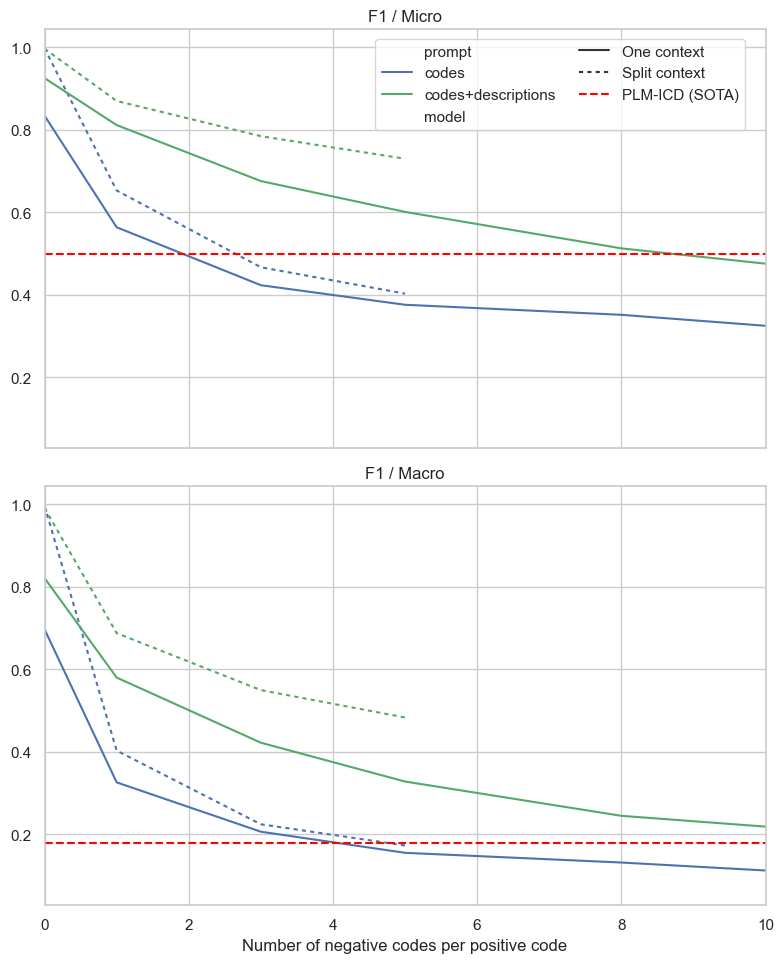

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot style
sns.set_theme(style="whitegrid")

# Define color palette by unique prompts
unique_prompts = plot_df["prompt"].unique()
prompt_order = ["codes", "codes+descriptions"]
palette = dict(zip(unique_prompts, sns.color_palette(n_colors=len(unique_prompts))))

# Create vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)

plot_df = plot_df[(plot_df["prompt"] == "codes") | (plot_df["prompt"] == "codes+descriptions")]
# Plot for f1_micro (Top subplot)
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    style="model",
    style_order=["One context", "Split context"],
    dashes={"One context": "", "Split context": (2, 2)},
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("F1 / Micro")
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")
axes[0].set_xlim([0, 10])

# Plot for f1_macro (Bottom subplot)
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_macro",
    hue="prompt",
    hue_order=prompt_order,
    style="model",
    style_order=["One context", "Split context"],
    dashes={"One context": "", "Split context": (2, 2)},
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("F1 / Macro")
axes[1].axhline(y=0.18, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")
axes[1].set_xlim([0, 10])

# Axis labels (set only on the bottom for clarity)
axes[1].set_xlabel("Number of negative codes per positive code")
axes[0].yaxis.label.set_visible(False)
axes[1].yaxis.label.set_visible(False)

# Shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.71, 0.94),
    ncol=2,
    columnspacing=1.5
)

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


/var/folders/wq/887fx0qd7rj2gpt8w2x8cskh0000gp/T/ipykernel_3013/345779468.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["prompt"] = plot_df["prompt"].replace(prompt_label_map)


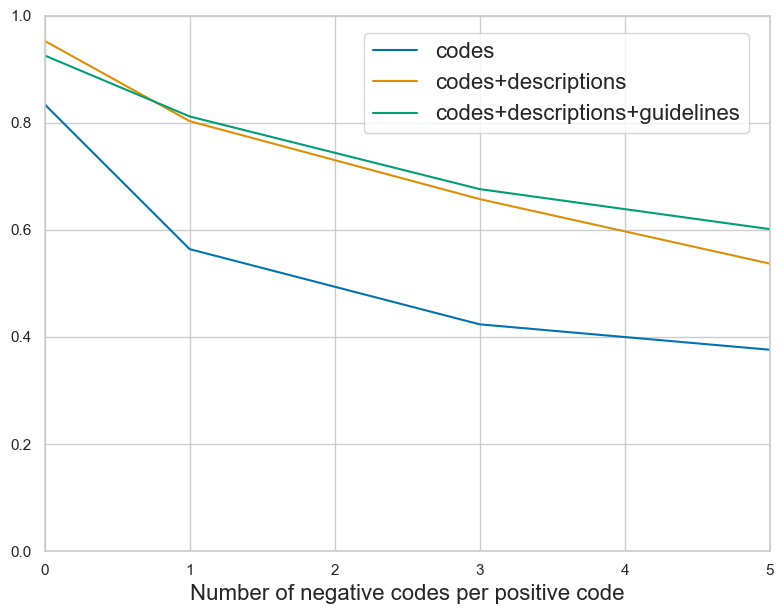

In [15]:
# Recreate the plot with the legend placed in the top right corner
# Set up the plot style
plot_df = df[(df["prompt_type"] == "Reasoning") & (df["model"] == "One context")]
sns.set_theme(style="whitegrid")


# Define color palette by unique prompts
# Replace prompt labels
prompt_label_map = {
    "codes": "codes",
    "codes+descriptions+notes": "codes+descriptions",
    "codes+descriptions": "codes+descriptions+guidelines",
}
plot_df["prompt"] = plot_df["prompt"].replace(prompt_label_map)

# Update the prompt order accordingly
prompt_order = ["codes", "codes+descriptions", "codes+descriptions+guidelines"]

fig, ax = plt.subplots(figsize=(8, 6))

# Plot for f1_micro
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    palette="colorblind",
    ax=ax
)
# ax.set_title("F1 / Micro")
ax.set_ylabel(None)
ax.set_xlabel("Number of negative codes per positive code", fontsize=16)
ax.set_xlim([0, 5])
ax.set_ylim([0.0, 1.0])

# Remove the automatic legend
ax.legend_.remove()

# Custom legend in the top right
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title=None,
    loc='upper right',
    bbox_to_anchor=(0.96, 1.0),
    ncol=1,
    columnspacing=1.5,
    prop={'size': 16}
)

plt.tight_layout(rect=[0, 0, 1, 1.05])
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot style
sns.set_theme(style="whitegrid")

# Define color palette by unique prompts
unique_prompts = plot_df["prompt"].unique()
prompt_order = ["codes", "codes+descriptions"]
palette = dict(zip(unique_prompts, sns.color_palette(n_colors=len(unique_prompts))))

# Create vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)

plot_df = plot_df[(plot_df["prompt"] == "codes") | (plot_df["prompt"] == "codes+descriptions")]
# Plot for f1_micro (Top subplot)
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    style="model",
    style_order=["One context", "Split context"],
    dashes={"One context": "", "Split context": (2, 2)},
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("F1 / Micro")
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")
axes[0].set_xlim([0, 10])

# Plot for f1_macro (Bottom subplot)
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_macro",
    hue="prompt",
    hue_order=prompt_order,
    style="model",
    style_order=["One context", "Split context"],
    dashes={"One context": "", "Split context": (2, 2)},
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("F1 / Macro")
axes[1].axhline(y=0.18, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")
axes[1].set_xlim([0, 10])

# Axis labels (set only on the bottom for clarity)
axes[1].set_xlabel("Number of negative codes per positive code")
axes[0].yaxis.label.set_visible(False)
axes[1].yaxis.label.set_visible(False)

# Shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.71, 0.94),
    ncol=2,
    columnspacing=1.5
)

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [32]:
df.to_csv("~/Downloads/assign_agent_experiments.csv", index=False)
df.head(5)

,f1_micro,f1_macro,micro_recall,micro_precision,accuracy,prediction-bias-ratio,experiment,model,dataset,prompt,negatives,seed
1,0.402999,0.173305,0.399091,0.406984,0.136691,0.980606,mock-negatives-single,Split Context,mdace-icd10cm,codes,5,1
4,0.652986,0.403248,0.646061,0.660062,0.253597,0.978788,mock-negatives-single,Split Context,mdace-icd10cm,codes,1,1
5,0.995892,0.991248,0.991818,1.000000,0.955036,0.991818,mock-negatives-single,Split Context,mdace-icd10cm,codes+descriptions+notes,0,1
6,0.467013,0.224692,0.463333,0.470751,0.160072,0.984242,mock-negatives-single,Split Context,mdace-icd10cm,codes,3,1
8,0.719215,0.482414,0.710606,0.728035,0.336331,0.976061,mock-negatives-single,Split Context,mdace-icd10cm,codes+descriptions+notes,5,1


In [30]:
def plot_metric_over_negatives(ax: plt.Axes, df: pd.DataFrame, metric: str, title: str) -> None:
    # Set a color palette for better readability
    palette = sns.color_palette()
    
    # Aggregating the data to calculate mean, min, and max for the specified metric
    agg_df = df.groupby(['prompt', 'negatives'])[metric].agg(['mean', 'min', 'max']).reset_index()

    # Plotting the line chart with shaded areas
    for i, exp in enumerate(agg_df['prompt'].unique()):
        subset = agg_df[agg_df['prompt'] == exp]
        ax.plot(subset['negatives'], subset['mean'], label=exp, marker='o', color=palette[i])
        ax.fill_between(subset['negatives'], subset['min'], subset['max'], alpha=0.2, color=palette[i])

    # Labeling the plot
    ax.set_xlabel('Number of Candidate Codes')
    ax.set_ylabel(f'Metric: {metric}')
    ax.set_title(title)
    ax.grid(True)


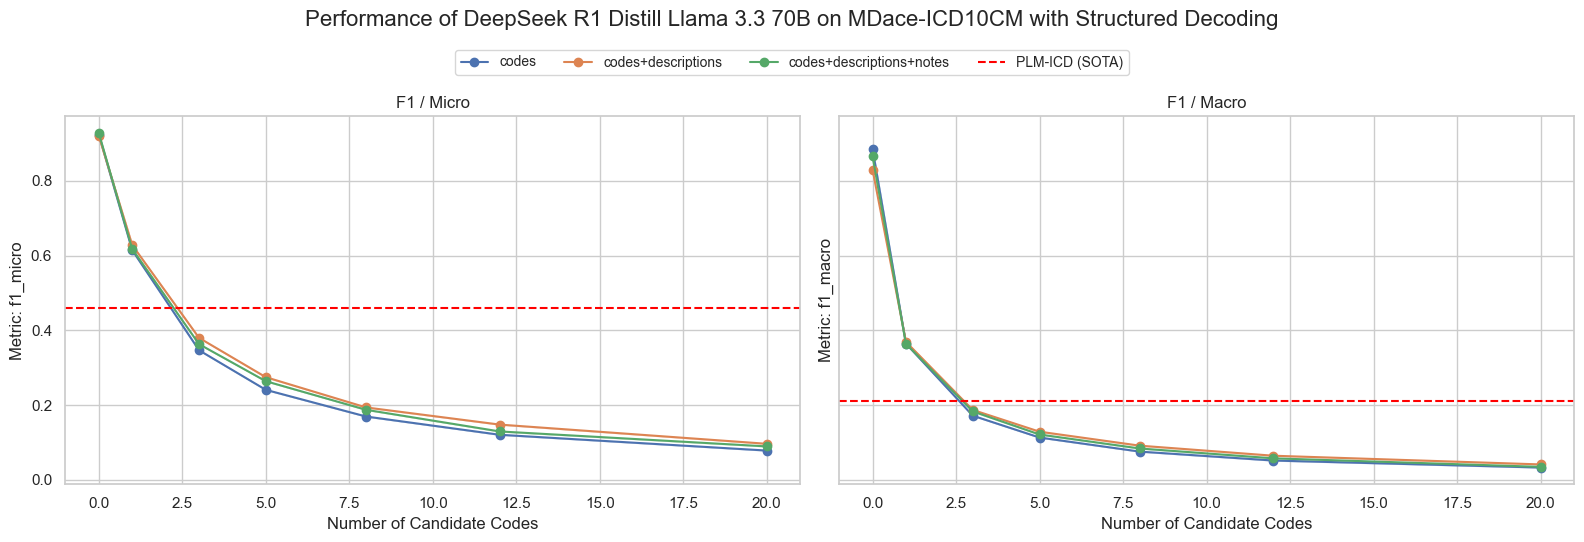

In [31]:
# Create subplots
title = "Performance of DeepSeek R1 Distill Llama 3.3 70B on MDace-ICD10CM with Structured Decoding"
subtitle = ["F1 / Micro", "F1 / Macro"]
metrics = ["f1_micro", "f1_macro"]
baselines = [("PLM-ICD (SOTA)", 0.46), ("PLM-ICD (SOTA)", 0.21)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# To store handles and labels for the shared legend
handles, labels = [], []

# Plot each metric on a separate subplot
plot_df = df[(df["prompt_type"] == "Structured")]
for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    plot_metric_over_negatives(ax, plot_df, metric, subtitle[idx])

    # Collect legend elements only for the second subplot
    label, value = baselines[idx]
    ax.axhline(y=value, color='red', linestyle='--', linewidth=1.5, label=label)
    if idx == 1:  # Skip legend for the first axis
        ax_handles, ax_labels = ax.get_legend_handles_labels()
        handles.extend(ax_handles)
        labels.extend(ax_labels)

# Add the shared legend inside the plot area
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.83), ncol=4, fontsize=10, frameon=True)

# Add the figure title
fig.suptitle(title, fontsize=16, y=0.95)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.05, 1, 0.9])  # Leave space for the legend and title
plt.show()

In [38]:
df_plot.head(10)

,f1_micro,f1_macro,micro_recall,micro_precision,accuracy,prediction-bias-ratio,experiment,model,dataset,prompt,negatives,seed,prompt_type
17,0.512758,0.245211,0.511515,0.514007,0.215827,0.995152,mock-negatives,One context,mdace-icd10cm,codes+descriptions,8,1,Reasoning
18,0.078136,0.032720,0.162121,0.051472,0.000000,3.149697,mock-negatives,One context,mdace-icd10cm,codes,20,1,Structured
19,0.536820,0.269473,0.575455,0.503046,0.251799,1.143939,mock-negatives,One context,mdace-icd10cm,codes+descriptions+notes,5,1,Reasoning
20,0.263838,0.121148,0.390000,0.199349,0.017986,1.956364,mock-negatives,One context,mdace-icd10cm,codes+descriptions+notes,5,1,Structured
21,0.193642,0.091270,0.302727,0.142348,0.025180,2.126667,mock-negatives,One context,mdace-icd10cm,codes+descriptions,8,1,Structured
24,0.270155,0.074736,0.269091,0.271228,0.043165,0.992121,mock-negatives,One context,mdace-icd10cm,codes,20,1,Reasoning
25,0.657265,0.385607,0.677879,0.637867,0.285971,1.062727,mock-negatives,One context,mdace-icd10cm,codes+descriptions+notes,3,1,Reasoning
26,0.834334,0.697135,0.715758,1.000000,0.428058,0.715758,mock-negatives,One context,mdace-icd10cm,codes,0,1,Reasoning
27,0.617681,0.364091,0.720909,0.540313,0.077338,1.334242,mock-negatives,One context,mdace-icd10cm,codes+descriptions+notes,1,1,Structured
28,0.802828,0.569259,0.791515,0.814468,0.379496,0.971818,mock-negatives,One context,mdace-icd10cm,codes+descriptions+notes,1,1,Reasoning


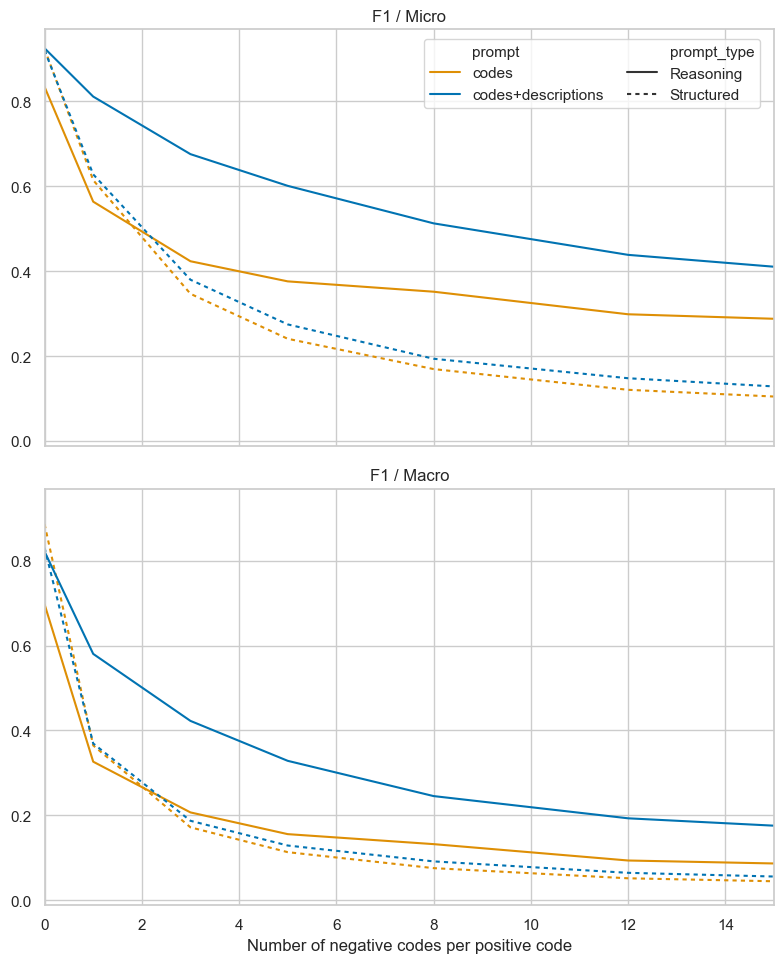

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_df = df[(df["model"] == "One context") & (df["prompt"] != "codes+descriptions+notes")]

# Set up the plot style
sns.set_theme(style="whitegrid")

# Define color palette by unique prompts
unique_prompts = plot_df["prompt"].unique()
prompt_order = ["codes", "codes+descriptions"]
palette = dict(zip(unique_prompts, sns.color_palette("colorblind", n_colors=len(unique_prompts))))
# Create vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)

# Plot for f1_micro (Top subplot)
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    style="prompt_type",
    style_order=["Reasoning", "Structured"],
    dashes={"Reasoning": "", "Structured": (2, 2)},
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("F1 / Micro")
axes[0].set_xlim([0, 10])
# axes[0].text(-0.1, 0.95, "A", transform=axes[0].transAxes,
#                 fontsize=16, fontweight="bold", va="top")

# Plot for f1_macro (Bottom subplot)
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_macro",
    hue="prompt",
    hue_order=prompt_order,
    style="prompt_type",
    style_order=["Reasoning", "Structured"],
    dashes={"Reasoning": "", "Structured": (2, 2)},
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("F1 / Macro")
axes[1].set_xlim([0, 15])

# Axis labels (set only on the bottom for clarity)
axes[1].set_xlabel("Number of negative codes per positive code")
axes[0].yaxis.label.set_visible(False)
axes[1].yaxis.label.set_visible(False)
# axes[1].text(-0.1, 0.95, "B", transform=axes[1].transAxes,
#                 fontsize=16, fontweight="bold", va="top")

# Shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.75, 0.94),
    ncol=2,
    columnspacing=1.5
)

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


ValueError: The palette dictionary is missing keys: {'Reasoning', 'Structured'}

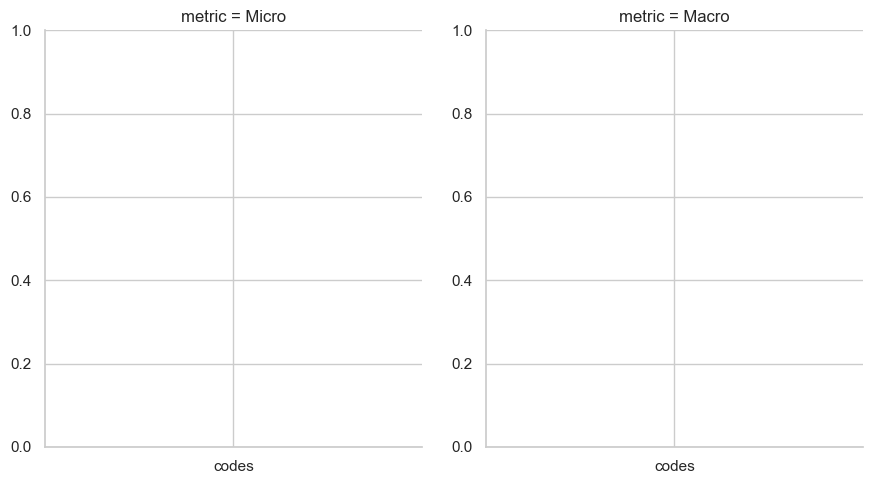

In [214]:
# 4. Build the two‑panel box plot
g = sns.catplot(
    data=melt_df,
    kind="box",
    x="prompt",
    y="f1",
    order=prompt_order,
    hue="prompt_type",
    hue_order=style_order,
    col="metric",
    col_order=["Micro", "Macro"],
    dodge=True,
    width=0.55,
    palette=palette,
    fliersize=1,
    sharey=False,
    height=5,
    aspect=0.9,
    legend=True,         # keep the legend (needed for handles)
    legend_out=False      # keep it inside the grid
)

g.set_titles("{col_name}")     # facet titles: Micro, Macro
g.set_axis_labels("", "F1")    # remove x‑axis label

# 5. Drop the figure‑level legend and add one inside the right subplot
if g._legend is not None:      # remove the global legend
    g._legend.remove()

right_ax = g.axes[0][1]        # Macro panel
handles, labels = right_ax.get_legend_handles_labels()
right_ax.legend(
    handles[:2], labels[:2],   # Reasoning, Structured
    title=None,
    loc="upper left",
    bbox_to_anchor=(0.02, 0.95),  # small inset from the corner
    frameon=False
)

# 6. Title and layout
g.figure.subplots_adjust(top=0.85)
# g.figure.suptitle(
#     "Distribution of F1 scores by prompt and decoding strategy",
#     fontsize=14
# )

plt.show()


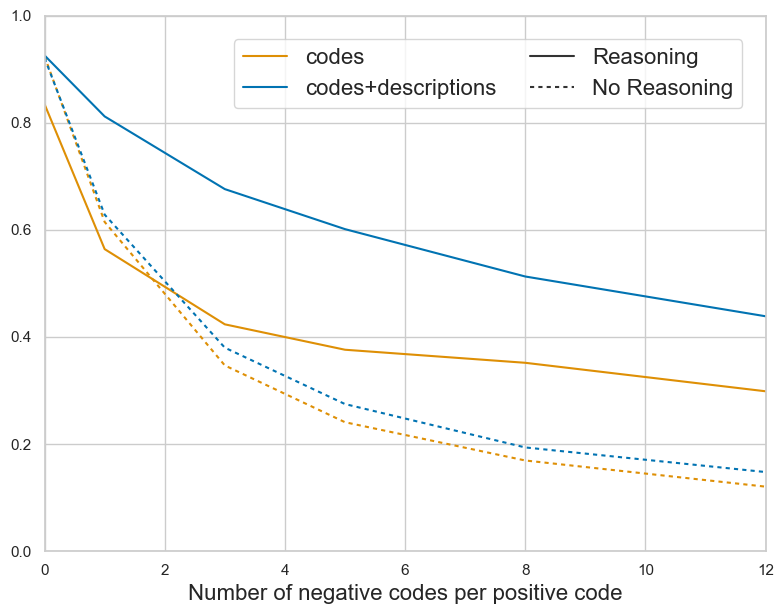

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy to avoid changing the original DataFrame
plot_df = df[(df["model"] == "One context") & (df["prompt"] != "codes+descriptions+notes")].copy()

# Replace 'Structured' with 'No Reasoning' in prompt_type
plot_df["prompt_type"] = plot_df["prompt_type"].replace({"Structured": "No Reasoning"})

# Set up the plot style
sns.set_theme(style="whitegrid")

# Define color palette by unique prompts
unique_prompts = plot_df["prompt"].unique()
prompt_order = ["codes", "codes+descriptions"]
palette = dict(zip(unique_prompts, sns.color_palette("colorblind", n_colors=len(unique_prompts))))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    style="prompt_type",
    style_order=["Reasoning", "No Reasoning"],
    dashes={"Reasoning": "", "No Reasoning": (2, 2)},
    palette=palette,
    ax=ax
)

ax.set_ylabel("")
ax.set_xlim([0, 12])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("Number of negative codes per positive code", fontsize=16)

# Shared legend
handles, labels = ax.get_legend_handles_labels()
drop = {"prompt", "prompt_type"}
handles = [h for h, l in zip(handles, labels) if l not in drop]
labels  = [l for        l in         labels if l not in drop]

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.62, 0.99),
    ncol=2,
    columnspacing=1.5,
    title=None,
    prop={"size": 16}
)

ax.legend_.remove()
plt.tight_layout(rect=[0, 0, 1, 1.05])
plt.show()


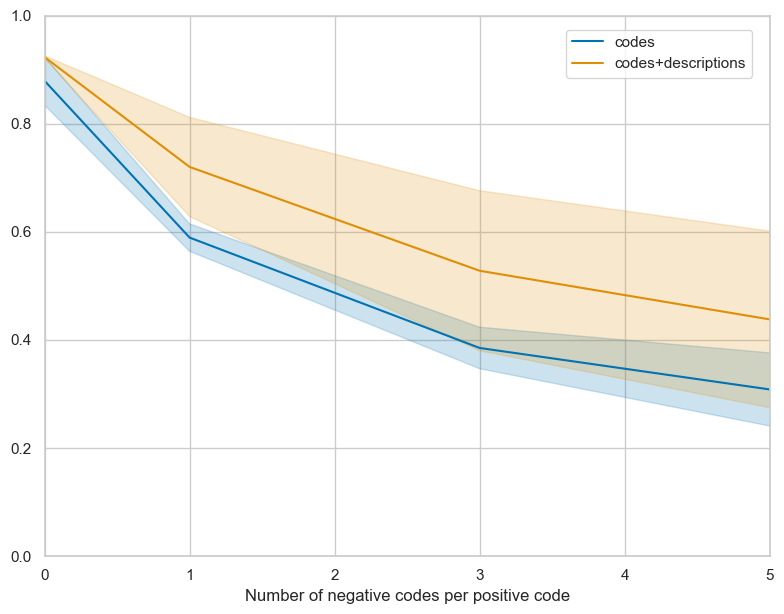

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_df = df[(df["model"] == "One context") & (df["prompt"] != "codes+descriptions+notes")]

# Set up the plot style
sns.set_theme(style="whitegrid")

# Define color palette by unique prompts
unique_prompts = plot_df["prompt"].unique()
prompt_order = ["codes", "codes+descriptions"]
palette = dict(zip(unique_prompts, sns.color_palette("colorblind", n_colors=len(unique_prompts))))
# Create vertically stacked subplots
fig, ax = plt.subplots(figsize=(8, 6))
# Plot for f1_micro
sns.lineplot(
    data=plot_df,
    x="negatives",
    y="f1_micro",
    hue="prompt",
    hue_order=prompt_order,
    style="prompt_type",
    style_order=["Reasoning", "No Reasoning"],
    dashes={"Reasoning": "", "No Reasoning": (2, 2)},
    palette=palette,
    ax=ax
)
# ax.set_title("F1 / Micro")
ax.set_ylabel(None)
ax.set_xlabel("Number of negative codes per positive code")
ax.set_xlim([0, 5])
ax.set_ylim([0.0, 1.0])

# Remove the automatic legend
ax.legend_.remove()

# Custom legend in the top right
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title=None,
    loc='upper right',
    bbox_to_anchor=(0.96, 1.0),
    ncol=1,
    columnspacing=1.5
)

plt.tight_layout(rect=[0, 0, 1, 1.05])
plt.show()

In [138]:
df_plot = df[df["model"] == "One context"].copy()

# Set up the plot style
sns.set_theme(style="whitegrid")

# Define color palette
unique_labels = df_plot["label"].unique()
palette = dict(zip(unique_labels, sns.color_palette("colorblind", n_colors=len(unique_labels))))

# Create vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 11), sharex=True, sharey=True)

# Supertitle
# fig.suptitle("Impact of Long-Context Reasoning and Contextual Enrichment", fontsize=14, fontweight='bold')

# Top: Micro F1
sns.lineplot(
    data=df_plot,
    x="negatives",
    y="f1_micro",
    hue="label",
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("Micro F1")
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")
axes[0].set_xlim([0, 10])
axes[0].text(-0.15, 1.05, "A", transform=axes[0].transAxes,
                fontsize=16, fontweight="bold", va="top")

# Bottom: Macro F1
sns.lineplot(
    data=df_plot,
    x="negatives",
    y="f1_macro",
    hue="label",
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Macro F1")
axes[1].axhline(y=0.18, color='red', linestyle='--', linewidth=1.5, label="PLM-ICD (SOTA)")
axes[1].set_xlim([0, 10])
axes[1].set_xlabel("Negatives per Positive Code")
axes[1].text(-0.15, 1.05, "B", transform=axes[1].transAxes,
                fontsize=16, fontweight="bold", va="top")

# Adjust y-axis labels only on left
axes[0].set_ylabel("F1 Score")
axes[1].set_ylabel("F1 Score")

# Unified legend outside plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.97),
    ncol=2,
    fontsize='small',
    columnspacing=1.2
)

# Remove internal legends
axes[0].legend_.remove()
axes[1].legend_.remove()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

KeyError: 'label'

In [36]:
df[df["model"] == "One context"]["prompt_type"].unique()

array(['Reasoning', 'Structured'], dtype=object)

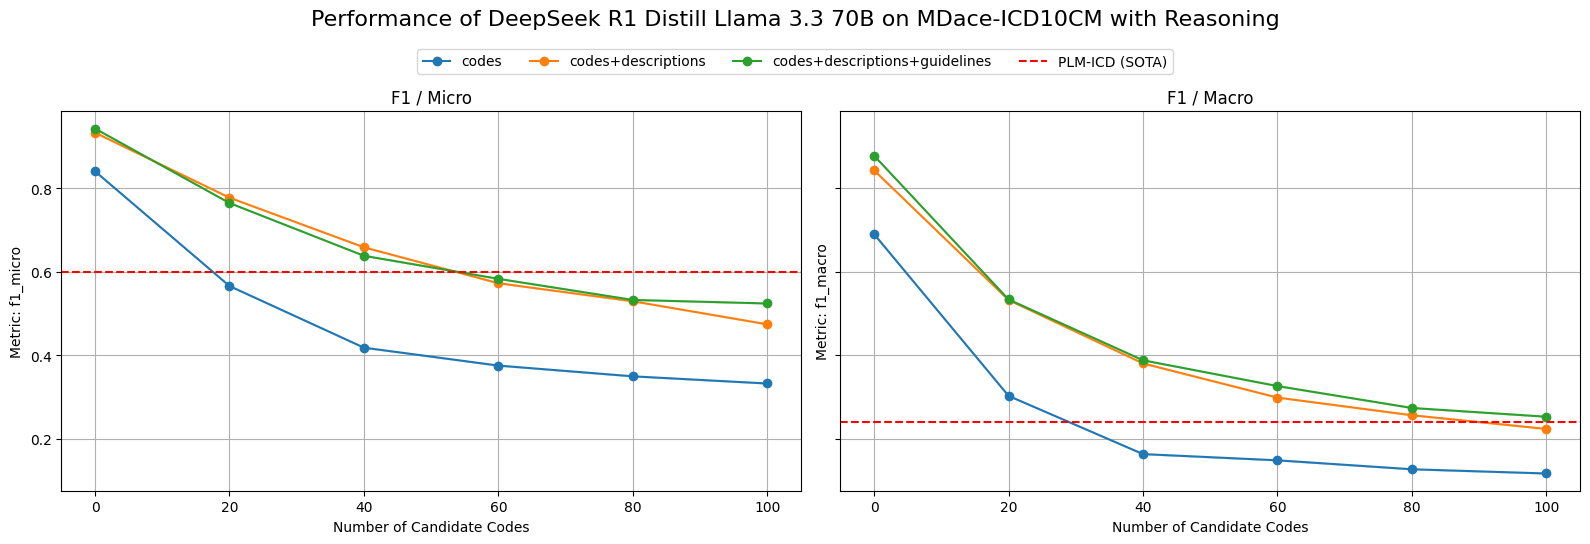

In [10]:
# Create subplots
title = "Performance of DeepSeek R1 Distill Llama 3.3 70B on MDace-ICD10CM with Reasoning"
subtitle = ["F1 / Micro", "F1 / Macro"]
metrics = ["f1_micro", "f1_macro"]
baselines = [("PLM-ICD (SOTA)", 0.60), ("PLM-ICD (SOTA)", 0.24)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# To store handles and labels for the shared legend
handles, labels = [], []

# Plot each metric on a separate subplot
plot_df = df[(df["model"] == "DeepSeek-R1-Distill-Llama-70B") & (df["prompt_type"] == "reas")]
for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    plot_metric_over_negatives(ax, plot_df, metric, subtitle[idx])

    # Collect legend elements only for the second subplot
    label, value = baselines[idx]
    ax.axhline(y=value, color='red', linestyle='--', linewidth=1.5, label=label)
    if idx == 1:  # Skip legend for the first axis
        ax_handles, ax_labels = ax.get_legend_handles_labels()
        handles.extend(ax_handles)
        labels.extend(ax_labels)

# Add the shared legend inside the plot area
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.83), ncol=4, fontsize=10, frameon=True)

# Add the figure title
fig.suptitle(title, fontsize=16, y=0.95)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.05, 1, 0.9])  # Leave space for the legend and title
plt.show()

In [12]:
def plot_shot_metrics(df: pd.DataFrame, metric: str) -> None:
    # Set a color palette for better readability
    palette = sns.color_palette("Set1")
    # Aggregating the data to calculate mean, min, and max for the specified metric
    agg_df = df.groupby(['shots', 'experiment'])[metric].agg(['mean', 'min', 'max']).reset_index()

    # Plotting the line chart with shaded areas
    plt.figure(figsize=(12, 8))
    for i, exp in enumerate(agg_df['experiment'].unique()):
        subset = agg_df[agg_df['experiment'] == exp]
        plt.plot(subset['shots'], subset['mean'], label=exp, color=palette[i])
        plt.fill_between(subset['shots'], subset['min'], subset['max'], alpha=0.2, color=palette[i])

    # Labeling the plot
    plt.xlabel('Number of Shots')
    plt.ylabel(f'Metric: {metric}')
    plt.title(f'{metric} across different number of shots (Llama 70B Instruct)')
    plt.legend(title='Experiments')
    plt.grid(True)
    plt.show()

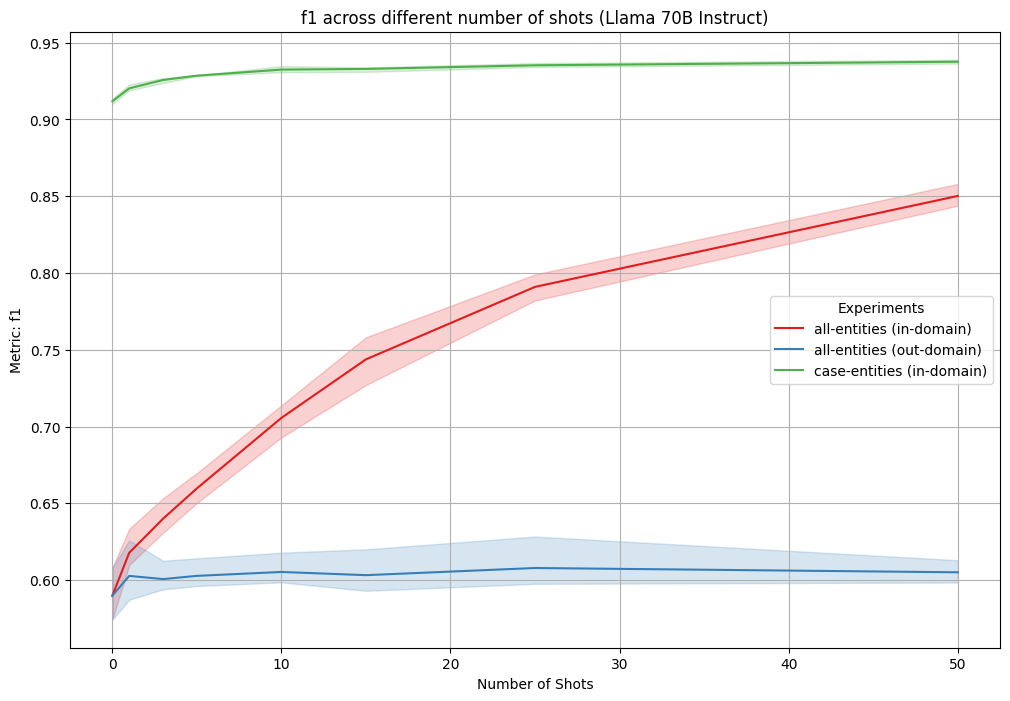

In [30]:
plot_shot_metrics(df, 'f1')

In [49]:
path_to_dir = pathlib.Path("~/research/remote-data/").expanduser()
paths = [path_to_dir/"zero-shot-negative-sampling"]
df = load_data_from_folders(paths, 'negatives')
df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])

In [50]:
df

,experiment,negatives,seed,recall,precision,exact_match,positive_ratio,negative_ratio,f1
0,zero-shot-negative-sampling,0,seed1,0.933967,0.913633,0.837233,0.954467,0.958633,0.923688
1,zero-shot-negative-sampling,0,seed2,0.943733,0.906633,0.831367,0.967033,0.952533,0.924811
2,zero-shot-negative-sampling,0,seed3,0.948800,0.888767,0.826733,0.998433,0.952433,0.917803
3,zero-shot-negative-sampling,100,seed1,0.849633,0.514867,0.573867,1.106267,0.778233,0.641184
4,zero-shot-negative-sampling,100,seed2,0.846233,0.520233,0.586767,1.067033,0.825267,0.644346
5,zero-shot-negative-sampling,100,seed3,0.826933,0.523400,0.610833,0.959833,0.857600,0.641052
6,zero-shot-negative-sampling,10,seed1,0.939367,0.806000,0.772433,1.007700,0.927300,0.867588
7,zero-shot-negative-sampling,10,seed2,0.918300,0.824000,0.772033,0.982000,0.925933,0.868598
8,zero-shot-negative-sampling,10,seed3,0.933133,0.805833,0.755933,1.021033,0.893267,0.864824
9,zero-shot-negative-sampling,25,seed1,0.896200,0.701200,0.685600,1.026800,0.866233,0.786798


In [43]:
def plot_negatives_metrics(df: pd.DataFrame, metric: str) -> plt:
    # Set a color palette for better readability
    palette = sns.color_palette("Set1")
    # Aggregating the data to calculate mean, min, and max for the specified metric
    agg_df = df.groupby(['negatives', 'experiment'])[metric].agg(['mean', 'min', 'max']).reset_index()

    # Plotting the line chart with shaded areas
    plt.figure(figsize=(12, 8))
    for i, exp in enumerate(agg_df['experiment'].unique()):
        subset = agg_df[agg_df['experiment'] == exp]
        plt.plot(subset['negatives'], subset['mean'], label=exp, marker='o', color=palette[i])
        plt.fill_between(subset['negatives'], subset['min'], subset['max'], alpha=0.2, color=palette[i])

    # Labeling the plot
    plt.xlabel('Number of Negatives')
    plt.ylabel(f'Metric: {metric}')
    plt.title(f'{metric} with increasing number of sampled negatives (Llama 70B Instruct)')
    plt.legend(title='Experiments')
    plt.grid(True)
    return plt

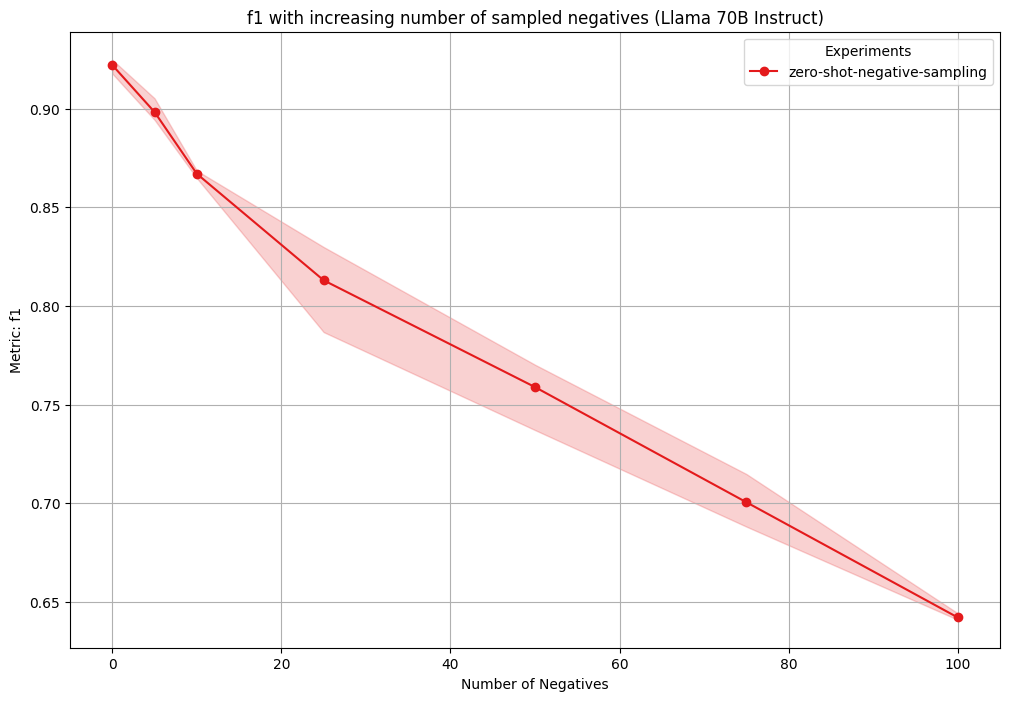

In [51]:
plot_negatives_metrics(df, 'f1')

In [44]:
def load_data_from_folders(paths: list[str], subfolder_key: str) -> pd.DataFrame:
    records = []
    for path in paths:
        main_folder = pathlib.Path(path).parent.name
        for subfolder in sorted(os.listdir(path)):
            subfolder_path = os.path.join(path, subfolder)
            if os.path.isdir(subfolder_path):
                value = int(subfolder.replace(subfolder_key, ''))
                for seed_folder in sorted(os.listdir(subfolder_path)):
                    seed_path = os.path.join(subfolder_path, seed_folder)
                    avg_file = os.path.join(seed_path, 'averages.json')
                    if os.path.exists(avg_file):
                        with open(avg_file, 'r') as f:
                            avg_data = json.load(f)
                            record = {'experiment': main_folder, subfolder_key: value, 'seed': seed_folder}
                            record.update(avg_data)
                            records.append(record)
    return pd.DataFrame(records)

In [45]:
path_to_dir = pathlib.Path("~/research/remote_data/unconstrained-code-description/4f3f78891df3881eacb94d9fdd1e183f").expanduser()
paths = [path_to_dir/f"mdace-diagnosis-{idx}/0shots" for idx in range(3, 8)]
df = load_data_from_folders(paths, 'negatives')
df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])

<module 'matplotlib.pyplot' from '/Users/amo/Library/Caches/pypoetry/virtualenvs/entityseeker-61_gtUVj-py3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

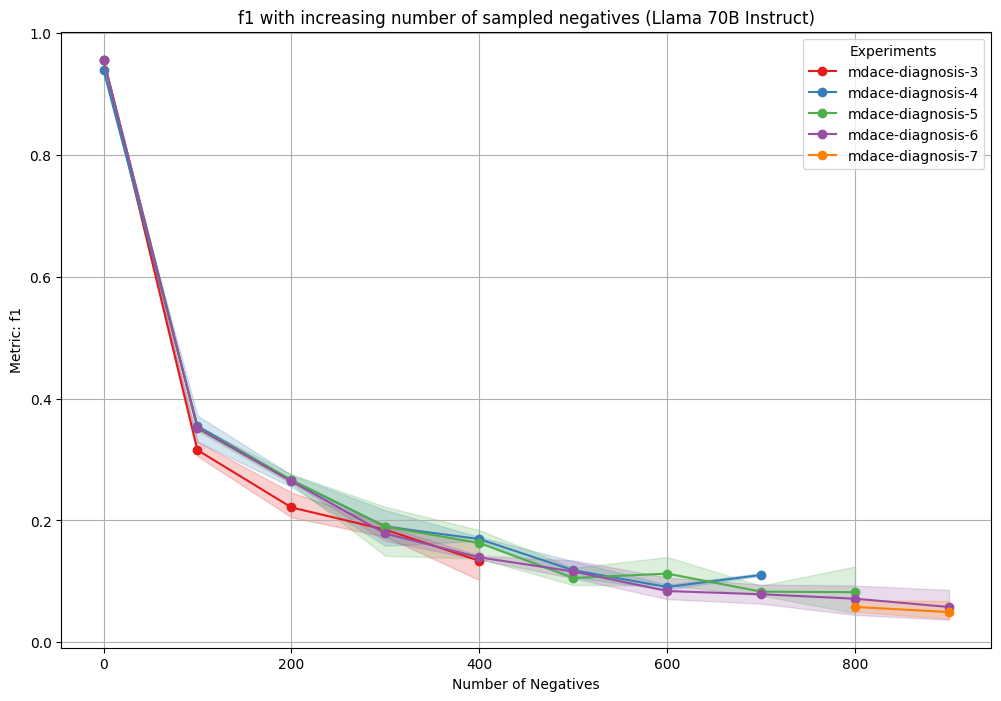

In [46]:
plot_negatives_metrics(df, 'f1')

In [47]:
path_to_dir = pathlib.Path("~/research/remote_data/constrained-code-description/380bbf28376f46f5db9b1b14bdf7bcce").expanduser()
paths = [path_to_dir/f"mdace-diagnosis-{idx}/0shots" for idx in range(3, 8)]
df = load_data_from_folders(paths, 'negatives')
df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])

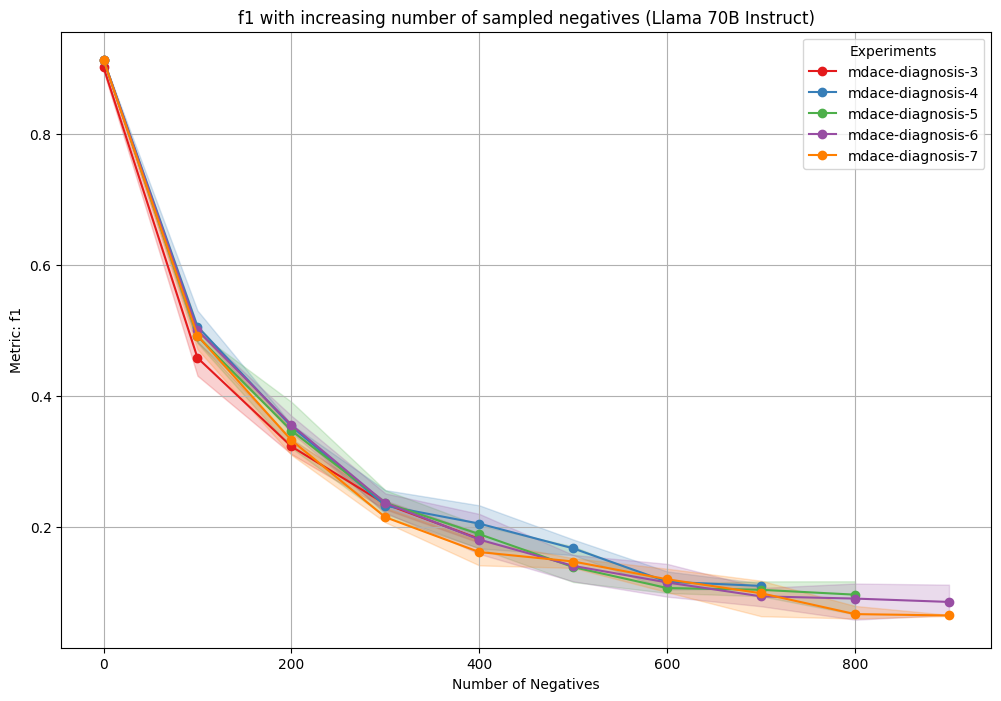

In [48]:
plot = plot_negatives_metrics(df, 'f1')
plot.show()

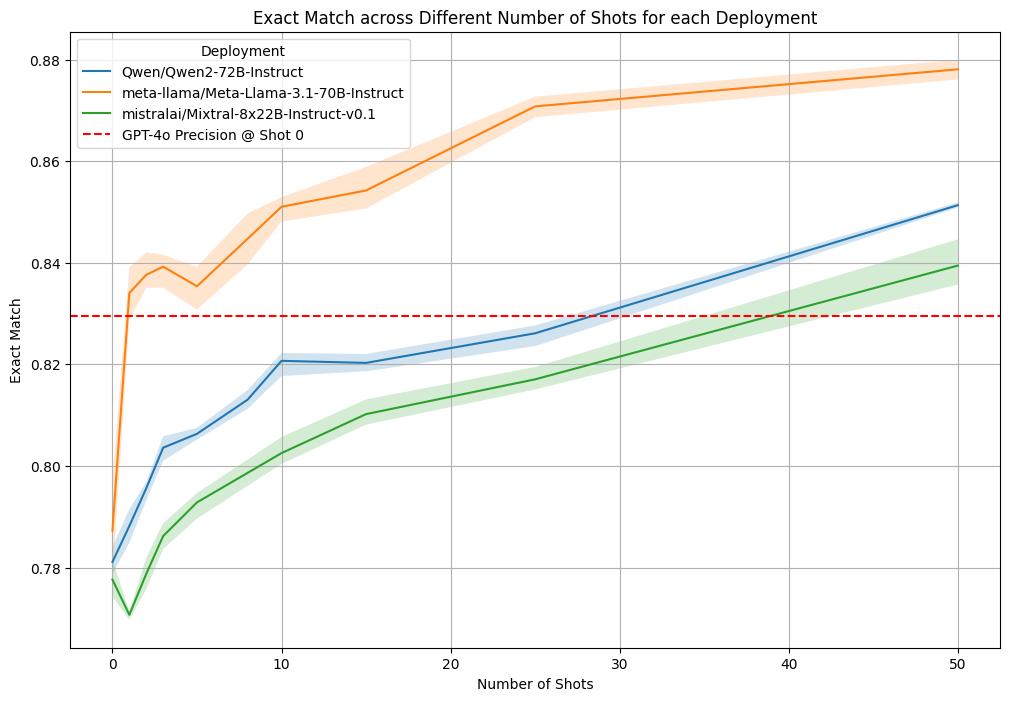

In [28]:
# Aggregating the data to calculate mean, min, and max for precision/mean
agg_df = df.groupby(['num_shots', 'deployment'])['exact_match/mean'].agg(['mean', 'min', 'max']).reset_index()

# Plotting the line chart with shaded areas
plt.figure(figsize=(12, 8))
for prompt in agg_df['deployment'].unique():
    subset = agg_df[agg_df['deployment'] == prompt]
    plt.plot(subset['num_shots'], subset['mean'], label=prompt)
    plt.fill_between(subset['num_shots'], subset['min'], subset['max'], alpha=0.2)

# Adding horizontal dotted red lines for GPT-4o and GPT-4-turbo
plt.axhline(y=0.8296, color='red', linestyle='--', label='GPT-4o @ Shot 0')

plt.xlabel('Number of Shots')
plt.ylabel('Exact Match')
plt.title('Exact Match across Different Number of Shots for each Deployment')
plt.legend(title='Deployment')
plt.grid(True)
plt.show()

In [62]:
rename_dict = {
    "mdace-diagnosis-3": "icd10cm 3",
    "mdace-diagnosis-4": "icd10cm 3.1",
    "mdace-diagnosis-5": "icd10cm 3.2",
    "mdace-diagnosis-6": "icd10cm 3.3",
    "mdace-diagnosis-7": "icd10cm 3.4"
}

def plot_negatives_metrics(ax: plt.Axes, df: pd.DataFrame, metric: str, title: str) -> None:
    # Set a color palette for better readability
    palette = sns.color_palette("Set1")
    # Aggregating the data to calculate mean, min, and max for the specified metric
    agg_df = df.groupby(['negatives', 'experiment'])[metric].agg(['mean', 'min', 'max']).reset_index()

    # Plotting the line chart with shaded areas
    for i, exp in enumerate(agg_df['experiment'].unique()):
        subset = agg_df[agg_df['experiment'] == exp]
        label = rename_dict.get(exp, exp)
        ax.plot(subset['negatives'], subset['mean'], label=label, marker='o', color=palette[i], )
        ax.fill_between(subset['negatives'], subset['min'], subset['max'], alpha=0.2, color=palette[i])

    # Labeling the plot
    ax.set_xlabel('Number of Negatives')
    ax.set_ylabel(f'Metric: {metric}')
    ax.set_title(title)
    ax.legend(title='Experiments')
    ax.grid(True)

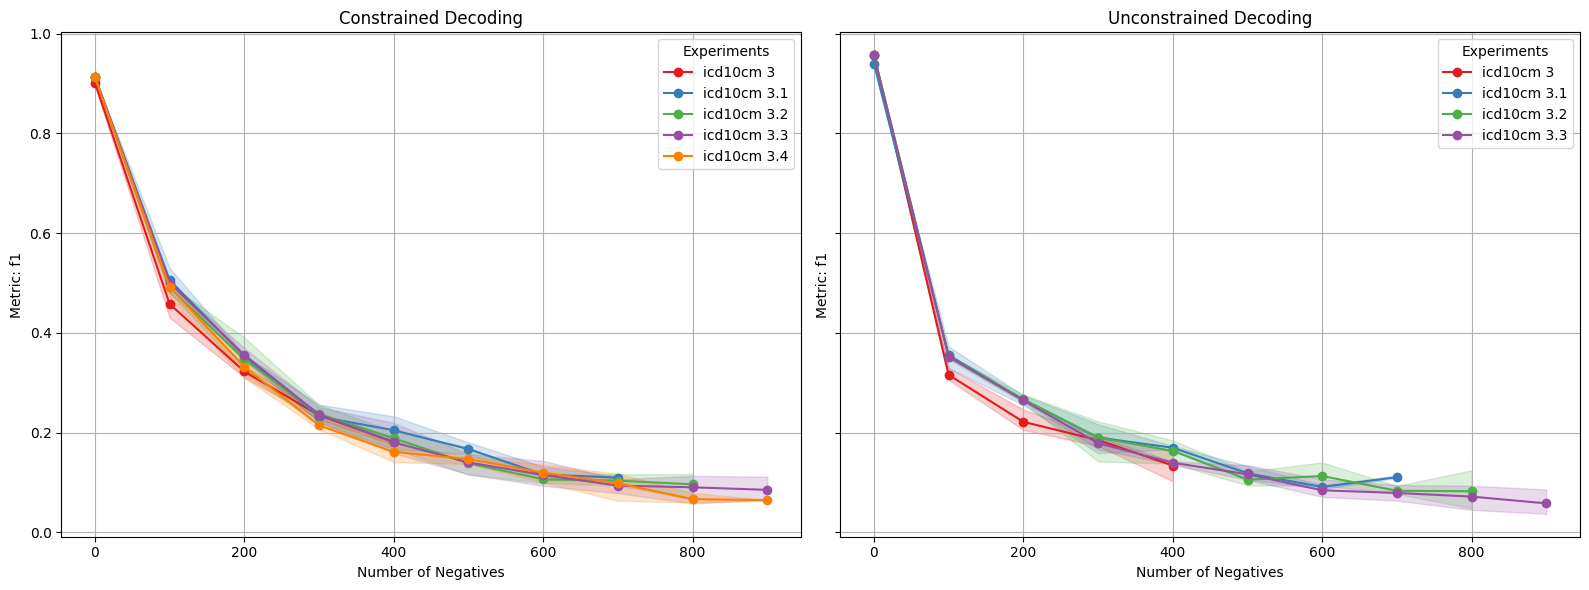

In [63]:
# Create subplots
titles = ["Constrained Decoding", "Unconstrained Decoding"]

path_to_dir = pathlib.Path("~/research/remote_data/constrained-code-description/380bbf28376f46f5db9b1b14bdf7bcce").expanduser()
paths = [path_to_dir/f"mdace-diagnosis-{idx}/0shots" for idx in range(3, 8)]
df1 = load_data_from_folders(paths, 'negatives')
df1["f1"] = 2 * (df1["precision"] * df1["recall"]) / (df1["precision"] + df1["recall"])

path_to_dir = pathlib.Path("~/research/remote_data/unconstrained-code-description/4f3f78891df3881eacb94d9fdd1e183f").expanduser()
paths = [path_to_dir/f"mdace-diagnosis-{idx}/0shots" for idx in range(3, 7)]
df2 = load_data_from_folders(paths, 'negatives')
df2["f1"] = 2 * (df["precision"] * df2["recall"]) / (df2["precision"] + df2["recall"])

dfs = [df1, df2]
fig, axes = plt.subplots(1, len(dfs), figsize=(16, 6), sharey=True)

# Plot each metric on a separate subplot
for idx, (ax, df) in enumerate(zip(axes, dfs)):
    plot_negatives_metrics(ax, df, "f1", titles[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

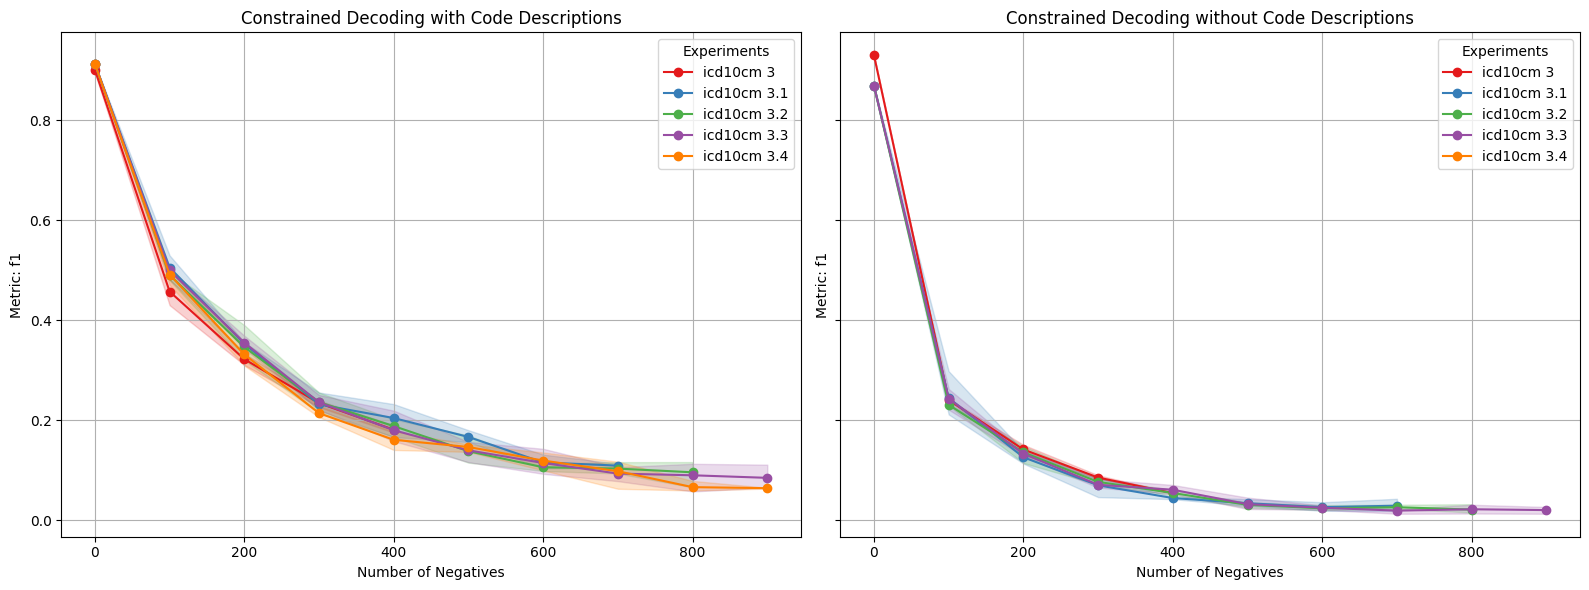

In [65]:
# Create subplots
titles = ["Constrained Decoding with Code Descriptions", "Constrained Decoding without Code Descriptions"]

path_to_dir = pathlib.Path("~/research/remote_data/constrained-code-description/380bbf28376f46f5db9b1b14bdf7bcce").expanduser()
paths = [path_to_dir/f"mdace-diagnosis-{idx}/0shots" for idx in range(3, 8)]
df1 = load_data_from_folders(paths, 'negatives')
df1["f1"] = 2 * (df1["precision"] * df1["recall"]) / (df1["precision"] + df1["recall"])

path_to_dir = pathlib.Path("~/research/remote_data/constrained-code-no-description/edf6625ce2ba58a39dcce00c8ec753dd").expanduser()
paths = [path_to_dir/f"mdace-diagnosis-{idx}/0shots" for idx in range(3, 8)]
df2 = load_data_from_folders(paths, 'negatives')
df2["f1"] = 2 * (df["precision"] * df2["recall"]) / (df2["precision"] + df2["recall"])

dfs = [df1, df2]
fig, axes = plt.subplots(1, len(dfs), figsize=(16, 6), sharey=True)

# Plot each metric on a separate subplot
for idx, (ax, df) in enumerate(zip(axes, dfs)):
    plot_negatives_metrics(ax, df, "f1", titles[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

KeyError: 'Retrieval'

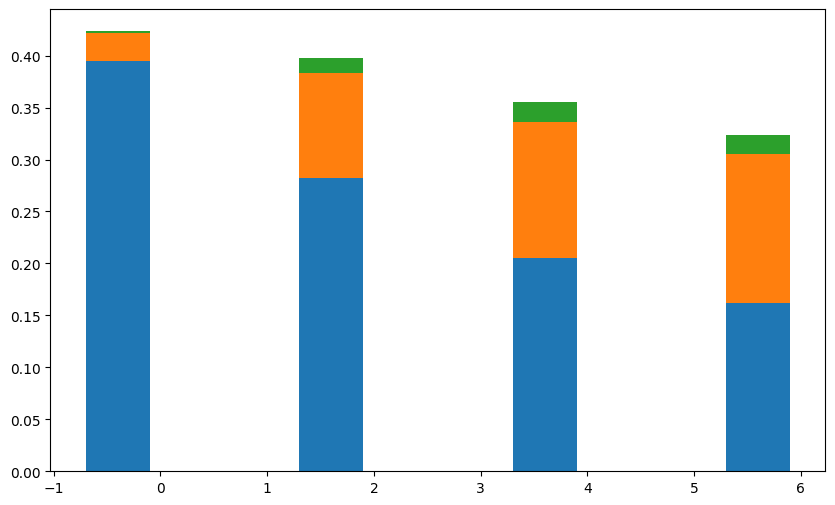

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data extracted from experiment log
ranks = [10, 25, 40, 55]

data_micro = {
    "Rank@k": [0.3945823907852173, 0.2825581431388855, 0.2054816037416458, 0.16162927448749542],
    "Verify Agent": [0.42189285159111023, 0.3829570710659027, 0.3361256420612335, 0.3054389953613281],
    "Assign Agent": [0.4234274625778198, 0.39747846126556396, 0.3554351031780243, 0.3235083818435669],
}

data_macro = {
    "Rank@k": [0.1850980818271637, 0.14737318456172943, 0.11193236708641052, 0.08727213740348816],
    "Verify Agent": [0.19305230677127838, 0.1935010552406311, 0.17868103086948395, 0.15853512287139893],
    "Assign Agent": [0.19410285353660583, 0.20051425695419312, 0.18727867305278778, 0.1694282740354538],
}

df_micro = pd.DataFrame(data_micro, index=ranks)
df_macro = pd.DataFrame(data_macro, index=ranks)

# Compute improvements (deltas) over previous agent
micro_retrieval = df_micro["Rank@k"].to_numpy()
micro_verify = (df_micro["Verify Agent"] - df_micro["Rank@k"]).to_numpy()
micro_assign = (df_micro["Assign Agent"] - df_micro["Verify Agent"]).to_numpy()

macro_retrieval = df_macro["Rank@k"].to_numpy()
macro_verify = (df_macro["Verify Agent"] - df_macro["Rank@k"]).to_numpy()
macro_assign = (df_macro["Assign Agent"] - df_macro["Verify Agent"]).to_numpy()

fig, ax = plt.subplots(figsize=(10, 6))
colors = {
    "Rank@k": "#1f77b4",  # blue
    "Verify": "#ff7f0e",     # orange
    "Assign": "#2ca02c"      # green
}
x_positions = np.arange(len(ranks)) * 2
x_micro = x_positions - 0.4
x_macro = x_positions + 0.4
bar_width = 0.6

# Plot Micro bars
ax.bar(x_micro, micro_retrieval, bar_width, label='Retrieval', color=colors["Rank@k"])
ax.bar(x_micro, micro_verify, bar_width, bottom=micro_retrieval, color=colors["Verify"])
ax.bar(x_micro, micro_assign, bar_width, bottom=micro_retrieval + micro_verify, color=colors["Assign"])

# Plot Macro bars
ax.bar(x_macro, macro_retrieval, bar_width, color=colors["Retrieval"])
ax.bar(x_macro, macro_verify, bar_width, bottom=macro_retrieval, color=colors["Verify"])
ax.bar(x_macro, macro_assign, bar_width, bottom=macro_retrieval + macro_verify, color=colors["Assign"])

# Add bottom labels below x-axis
for i in range(len(ranks)):
    ax.text(x_micro[i], -0.05, "Micro", ha='center', va='top', fontsize=9, fontweight='bold')
    ax.text(x_macro[i], -0.05, "Macro", ha='center', va='top', fontsize=9, fontweight='bold')

# Aesthetics
ax.set_xticks(x_positions)
ax.set_xticklabels(ranks) # type: ignore
ax.set_xlabel('@K')
ax.set_ylabel('F1 Score')
ax.set_title('F1 micro and macro scores by rank@k with incremental contributions')
ax.legend(loc='upper right')
# ax.set_ylim([0, 1.1])
ax.set_xlim([x_positions[0] - 1, x_positions[-1] + 1])
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


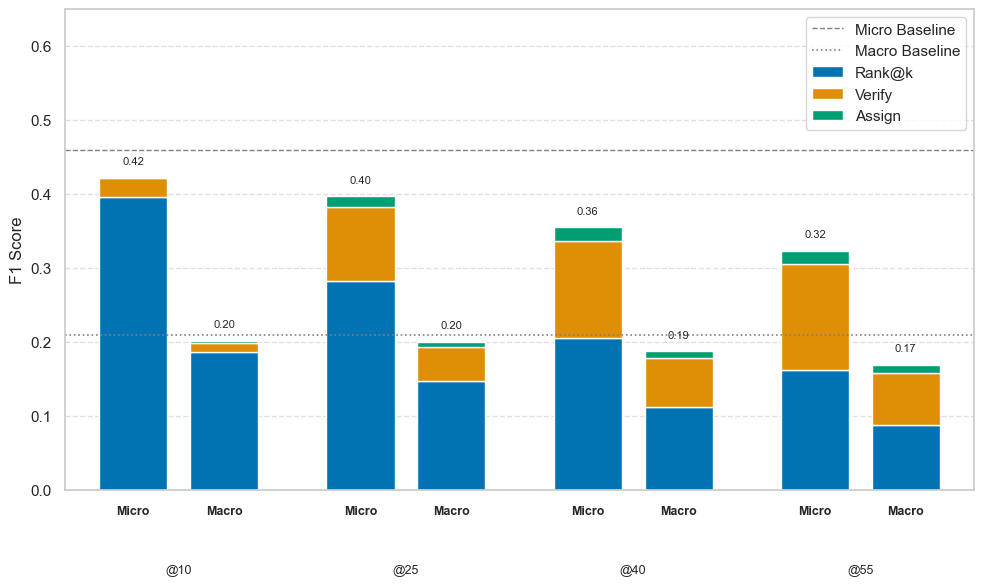

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
ranks = [10, 25, 40, 55]

data_micro = {
    "Rank@k": [0.3957823907852173, 0.2825581431388855, 0.2054816037416458, 0.16162927448749542],
    "Verify Agent": [0.42189285159111023, 0.3829570710659027, 0.3361256420612335, 0.3054389953613281],
    "Assign Agent": [0.4234274625778198, 0.39747846126556396, 0.3554351031780243, 0.3235083818435669],
}

data_macro = {
    "Rank@k": [0.1868598312139511, 0.14737318456172943, 0.11193236708641052, 0.08727213740348816],
    "Verify Agent": [0.1991189569234848, 0.1935010552406311, 0.17868103086948395, 0.15853512287139893],
    "Assign Agent": [0.20200929045677185, 0.20051425695419312, 0.18727867305278778, 0.1694282740354538],
}

df_micro = pd.DataFrame(data_micro, index=ranks)
df_macro = pd.DataFrame(data_macro, index=ranks)

# Compute improvements
micro_retrieval = df_micro["Rank@k"]
micro_verify = df_micro["Verify Agent"] - df_micro["Rank@k"]
micro_assign = df_micro["Assign Agent"] - df_micro["Verify Agent"]

macro_retrieval = df_macro["Rank@k"]
macro_verify = df_macro["Verify Agent"] - df_macro["Rank@k"]
macro_assign = df_macro["Assign Agent"] - df_macro["Verify Agent"]

# Colors
palette = sns.color_palette("colorblind")
colors = {
    "Rank@k": palette[0],  # blue
    "Verify": palette[1],  # orange
    "Assign": palette[2],  # green
}

# Convert to numpy arrays
micro_retrieval_np = micro_retrieval.to_numpy()
micro_verify_np = micro_verify.to_numpy()
micro_assign_np = micro_assign.to_numpy()

macro_retrieval_np = macro_retrieval.to_numpy()
macro_verify_np = macro_verify.to_numpy()
macro_assign_np = macro_assign.to_numpy()

# Positions
x_positions = np.arange(len(ranks)) * 2
x_micro = x_positions - 0.4
x_macro = x_positions + 0.4
bar_width = 0.6

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Micro bars
ax.bar(x_micro, micro_retrieval_np, bar_width, label='Rank@k', color=colors["Rank@k"])
ax.bar(x_micro, micro_verify_np, bar_width, bottom=micro_retrieval_np, label='Verify', color=colors["Verify"])
ax.bar(x_micro, micro_assign_np, bar_width, bottom=micro_retrieval_np + micro_verify_np, label='Assign', color=colors["Assign"])

# Plot Macro bars
ax.bar(x_macro, macro_retrieval_np, bar_width, color=colors["Rank@k"])
ax.bar(x_macro, macro_verify_np, bar_width, bottom=macro_retrieval_np, color=colors["Verify"])
ax.bar(x_macro, macro_assign_np, bar_width, bottom=macro_retrieval_np + macro_verify_np, color=colors["Assign"])

# Add absolute value labels
micro_top = micro_retrieval_np + micro_verify_np + micro_assign_np
macro_top = macro_retrieval_np + macro_verify_np + macro_assign_np
for i in range(len(ranks)):
    ax.text(x_micro[i], micro_top[i] + 0.015, f"{micro_top[i]:.2f}", ha='center', va='bottom', fontsize=8)
    ax.text(x_macro[i], macro_top[i] + 0.015, f"{macro_top[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Add horizontal baseline lines
ax.axhline(0.46, color='gray', linestyle='--', linewidth=1, label='Micro Baseline')
ax.axhline(0.21, color='gray', linestyle=':', linewidth=1.2, label='Macro Baseline')

# Custom x-axis labels
ax.set_xticks([])
for i in range(len(ranks)):
    ax.text(x_micro[i], -0.02, "Micro", ha='center', va='top', fontsize=9, fontweight='bold')
    ax.text(x_macro[i], -0.02, "Macro", ha='center', va='top', fontsize=9, fontweight='bold')
    ax.text((x_micro[i] + x_macro[i]) / 2, -0.10, f"@{ranks[i]}", ha='center', va='top', fontsize=9)

# Aesthetics
ax.set_ylabel('F1 Score')
ax.legend(loc='upper right')
ax.set_ylim([0, 0.65])
ax.set_xlim([x_positions[0] - 1, x_positions[-1] + 1])
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

